In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.4 MB/s eta 0:00:00


In [3]:
import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import ARMAConv

from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
data = np.load('/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/Medmnist_data/pneumoniamnist_224.npz', allow_pickle=True)
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N,3,224,224)
X = torch.tensor(images)
y = torch.tensor(all_labels).long()
print("Images, labels shapes:", X.shape, y.shape)

Images, labels shapes: torch.Size([5856, 3, 224, 224]) torch.Size([5856])


In [6]:
dataset = TensorDataset(X, y)
class0_indices = [i for i in range(len(y)) if y[i] == 0]
class1_indices = [i for i in range(len(y)) if y[i] == 1]

random.seed(SEED)
sampled_class0 = random.sample(class0_indices, min(2000, len(class0_indices)))
sampled_class1 = random.sample(class1_indices, min(2000, len(class1_indices)))

combined_indices = sampled_class0 + sampled_class1
random.shuffle(combined_indices)

final_dataset = Subset(dataset, combined_indices)
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=False)

In [7]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

resnet_feats = []
y_list = []
with torch.no_grad():
    for imgs, labels in final_loader:
        imgs = imgs.to(device)
        feats = resnet(imgs)
        resnet_feats.append(feats.cpu())
        y_list.extend(labels.cpu().tolist())

features = torch.cat(resnet_feats, dim=0).numpy().astype(np.float32)
y_labels = np.array(y_list).astype(np.int64)
print("Feature shape:", features.shape, "Label shape:", y_labels.shape)

num_nodes, feat_dim = features.shape

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 96.7MB/s]


Feature shape: (3583, 512) Label shape: (3583,)


In [8]:
def create_adj(features, cut, alpha=1.0):
    F_norm = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-12)
    W = np.dot(F_norm, F_norm.T)
    if cut == 0:
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        if W.max() > 0:
            W = (W / W.max()).astype(np.float32)
    else:
        W = (W * (W >= alpha)).astype(np.float32)
    return W

def edge_index_from_dense(W):
    rows, cols = np.nonzero(W > 0)
    edge_index = np.vstack([rows, cols]).astype(np.int64)
    edge_weight = W[rows, cols].astype(np.float32)
    return edge_index, edge_weight

def build_adj_list(edge_index_np, num_nodes):
    adj = [[] for _ in range(num_nodes)]
    src = edge_index_np[0]
    dst = edge_index_np[1]
    for s, d in zip(src, dst):
        adj[s].append(d)
    adj = [np.array(neis, dtype=np.int64) if len(neis) > 0 else np.array([], dtype=np.int64) for neis in adj]
    return adj

def aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=None):
    rng = np.random.default_rng(seed)
    E = edge_index_np.shape[1]
    keep_mask = rng.random(E) >= drop_percent
    new_edge_index = edge_index_np[:, keep_mask]
    return new_edge_index

def load_data_from_edge_index(node_feats_np, edge_index_np, device):
    node_feats = torch.from_numpy(node_feats_np).float()
    edge_index = torch.from_numpy(edge_index_np.astype(np.int64)).long()
    return node_feats, edge_index

def sim(h1, h2, tau=0.2):
    z1 = nnF.normalize(h1, dim=-1, p=2)
    z2 = nnF.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag() + 1e-12))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / (cross_sim.sum(dim=-1) + 1e-12))

In [9]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )
    def forward(self, x):
        return self.net(x)

In [10]:
class ARMAEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ="SELU", num_stacks=1, num_layers=1):
        super(ARMAEncoder, self).__init__()
        self.device = device
        activations = {
            "SELU": nnF.selu,
            "SiLU": nnF.silu,
            "GELU": nnF.gelu,
            "ELU": nnF.elu,
            "RELU": nnF.relu
        }
        self.act = activations.get(activ, nnF.elu)
        self.arma = ARMAConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,
            num_layers=num_layers,
            act=self.act,
            shared_weights=True,
            dropout=0.25
        )
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.arma(x, edge_index)
        x = self.dropout(x)
        x = self.batchnorm(x)
        logits = self.mlp(x)
        return logits

In [11]:
class EMA():
    def __init__(self, beta):
        self.beta = beta
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

In [12]:
def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [13]:
class ARMA(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.99, cut=True):
        super(ARMA, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        self.beta = 0.6

        self.online_encoder = ARMAEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)
        for p in self.target_encoder.parameters():
            p.requires_grad = False
        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)
        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        x1 = self.online_encoder(data1)
        logits1 = self.online_predictor(x1)
        S1 = nnF.softmax(logits1, dim=1)
        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnF.softmax(logits2, dim=1)
        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()
        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)
        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)
        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnF.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m + 1e-12)
        k = torch.tensor(self.num_clusters, device=self.device, dtype=torch.float32)
        n = S.shape[0]
        modularity_term = (-1.0 / (2.0 * m + 1e-12)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1.0
        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnF.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / (den + 1e-12))
        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / (torch.norm(St_S) + 1e-12) - I_S / (torch.norm(I_S) + 1e-12))
        return mincut_loss + ortho_loss

In [14]:
alpha = 0.9
hidden_dim = 256
K = 2
num_epochs = 2000

W0 = create_adj(features, cut=0, alpha=alpha)
edge_index_np, edge_weight_np = edge_index_from_dense(W0)
node_feats_all, edge_index_all = load_data_from_edge_index(features, edge_index_np, device)
data_full = Data(x=node_feats_all.to(device), edge_index=edge_index_all.to(device))
A1 = torch.from_numpy(W0).float().to(device)


=== Fold 1 ===
Epoch 0 | Total: 0.596492 | Cont: 8.013408 | CE: 0.720119 | Unsup: -0.124429
Epoch 1 | Total: 0.544810 | Cont: 8.022093 | CE: 0.668760 | Unsup: -0.124753
Epoch 500 | Total: -0.242171 | Cont: 7.624093 | CE: 0.062182 | Unsup: -0.305116
Epoch 1000 | Total: -0.280979 | Cont: 7.624486 | CE: 0.024592 | Unsup: -0.306334
Epoch 1500 | Total: -0.296034 | Cont: 7.628486 | CE: 0.010492 | Unsup: -0.307289
Fold 1 → Acc=0.9464 Prec=0.9467 Rec=0.9578 F1=0.9522 AUC=0.9868

=== Fold 2 ===
Epoch 0 | Total: 0.577419 | Cont: 8.012152 | CE: 0.702254 | Unsup: -0.125636
Epoch 1 | Total: 0.522632 | Cont: 8.012215 | CE: 0.648149 | Unsup: -0.126319
Epoch 500 | Total: -0.221079 | Cont: 7.625121 | CE: 0.083061 | Unsup: -0.304903
Epoch 1000 | Total: -0.259095 | Cont: 7.624134 | CE: 0.046467 | Unsup: -0.306324
Epoch 1500 | Total: -0.285900 | Cont: 7.609671 | CE: 0.020269 | Unsup: -0.306930
Fold 2 → Acc=0.9488 Prec=0.9544 Rec=0.9539 F1=0.9542 AUC=0.9876

=== Fold 3 ===
Epoch 0 | Total: 0.546230 | Cont

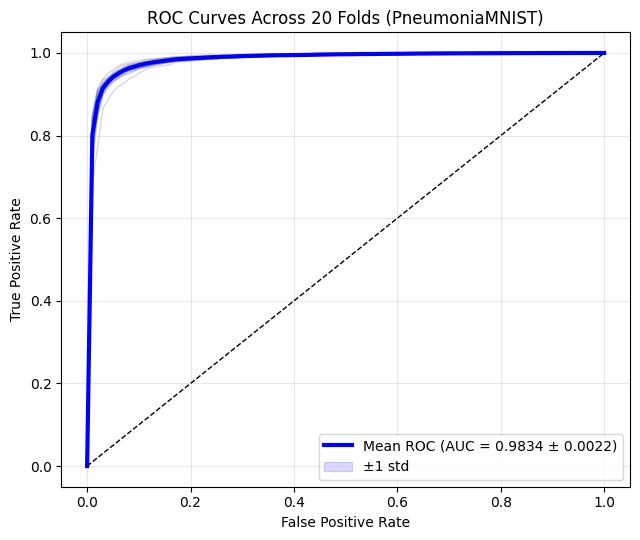

In [15]:
accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
auc_per_fold = []


sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=SEED)
for fold, (train_idx_full, test_idx) in enumerate(sss.split(features, y_labels)):
    print(f"\n=== Fold {fold+1} ===")

    cn_idx = np.where(y_labels == 0)[0]
    mci_idx = np.where(y_labels == 1)[0]
    sss_class = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=fold)
    cn_train_idx, _ = next(sss_class.split(features[cn_idx], y_labels[cn_idx]))
    mci_train_idx, _ = next(sss_class.split(features[mci_idx], y_labels[mci_idx]))
    cn_train = cn_idx[cn_train_idx]
    mci_train = mci_idx[mci_train_idx]
    balanced_train_idx = np.concatenate([cn_train, mci_train])
    np.random.shuffle(balanced_train_idx)

    train_idx_t = torch.from_numpy(balanced_train_idx).long().to(device)
    test_idx_t = torch.from_numpy(test_idx).long().to(device)
    y_tensor = torch.from_numpy(y_labels).long().to(device)

    model = ARMA(feat_dim, hidden_dim, K, device, activ="ELU", cut=False, moving_average_decay=0.99).to(device)
    classifier = nn.Linear(hidden_dim, K).to(device)
    optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=1e-4, weight_decay=1e-4)
    ce_loss = nn.CrossEntropyLoss()

    for ep in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        edge_index_aug1 = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=ep)
        edge_index_aug2 = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=ep+999)
        rng = np.random.default_rng(ep)
        mask = rng.random(features.shape) >= 0.2
        features_aug1 = (features * mask.astype(np.float32))
        aug_feat2 = features.copy()
        drop_feat_num = int(features.shape[0] * features.shape[1] * 0.2)
        flat_idx = rng.choice(features.shape[0] * features.shape[1], size=drop_feat_num, replace=False)
        rows = (flat_idx // features.shape[1])
        cols = (flat_idx % features.shape[1])
        aug_feat2[rows, cols] = 0.0
        features_aug2 = aug_feat2.astype(np.float32)
        node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, edge_index_aug1, device)
        data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))
        node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, edge_index_aug2, device)
        data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))
        S1, S2, logits1, logits2, l1, l2 = model(data1, data2)
        cont_loss = ((l1 + l2) / 2.0).mean()
        embeddings = model.online_encoder(data_full)
        logits_sup = classifier(embeddings[train_idx_t])
        sup_loss = ce_loss(logits_sup, y_tensor[train_idx_t])
        unsup_loss = model.loss(A1, logits1)
        loss = 0.0001 * cont_loss + sup_loss + unsup_loss
        loss.backward()
        optimizer.step()
        model.update_ma()

        if ep % 500 == 0 or ep == 1:
            print(f"Epoch {ep} | Total: {loss.item():.6f} | Cont: {cont_loss.item():.6f} | CE: {sup_loss.item():.6f} | Unsup: {unsup_loss.item():.6f}")

    # --- Eval ---
    model.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings_final = model.online_encoder(data_full)
        logits_final = classifier(embeddings_final)
        probs = nnF.softmax(logits_final, dim=1).cpu().numpy()
        y_pred = np.argmax(probs, axis=1)

    y_test = y_labels[test_idx]
    y_pred_test = y_pred[test_idx]
    y_proba_test = probs[test_idx, 1] if probs.shape[1] > 1 else probs[test_idx, 0]

    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    try:
        loss_val = log_loss(y_test, y_proba_test)
    except:
        loss_val = np.nan
    try:
        auc_score = roc_auc_score(y_test, y_proba_test)
    except:
        auc_score = np.nan
    try:
        fpr, tpr, _ = roc_curve(y_test, y_proba_test)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_per_fold.append(auc_score)
    except Exception:
        pass

    print(f"Fold {fold+1} → Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f} AUC={auc_score:.4f}")
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_score)

print("\n=== Average Results ===")
print(f"Accuracy: {np.nanmean(accuracies):.4f} ± {np.nanstd(accuracies):.4f}")
print(f"Precision: {np.nanmean(precisions):.4f} ± {np.nanstd(precisions):.4f}")
print(f"Recall: {np.nanmean(recalls):.4f} ± {np.nanstd(recalls):.4f}")
print(f"F1: {np.nanmean(f1_scores):.4f} ± {np.nanstd(f1_scores):.4f}")
print(f"LogLoss: {np.nanmean(losses):.4f} ± {np.nanstd(losses):.4f}")
print(f"AUC: {np.nanmean(all_auc):.4f} ± {np.nanstd(all_auc):.4f}")
# -------------------------
# Plot ROC curves (all folds + mean)
# -------------------------
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.nanstd(auc_per_fold)

plt.figure(figsize=(6.5, 5.5))

# Individual folds
for i in range(len(tprs)):
    plt.plot(mean_fpr, tprs[i], color="gray", lw=1, alpha=0.3)

# Mean ROC (highlighted)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=3,
    label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})"
)

# Std band
plt.fill_between(
    mean_fpr,
    np.maximum(mean_tpr - std_tpr, 0),
    np.minimum(mean_tpr + std_tpr, 1),
    color="blue",
    alpha=0.15,
    label="±1 std"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="black", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across 20 Folds (PneumoniaMNIST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


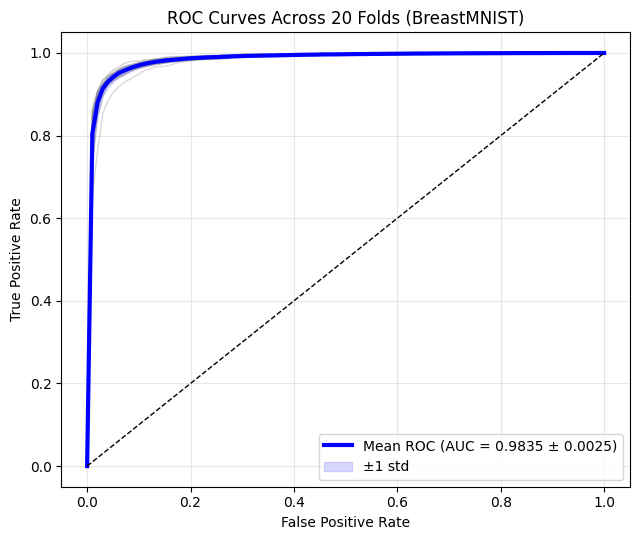

In [ ]:
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.nanstd(auc_per_fold)

plt.figure(figsize=(6.5, 5.5))

# Individual folds
for i in range(len(tprs)):
    plt.plot(mean_fpr, tprs[i], color="gray", lw=1, alpha=0.3)

# Mean ROC (highlighted)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=3,
    label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})"
)

# Std band
plt.fill_between(
    mean_fpr,
    np.maximum(mean_tpr - std_tpr, 0),
    np.minimum(mean_tpr + std_tpr, 1),
    color="blue",
    alpha=0.15,
    label="±1 std"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="black", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across 20 Folds (BreastMNIST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The underlying cause of the `TypeError` has been addressed by adding the necessary imports in an earlier cell (`obRUlNpQD4Pe`).

To correctly generate the plots and resolve the error in the plotting cell (`DBPWI0zONP-O`), you need to:

1.  **Re-run the training and evaluation cell (`W46yr-cAEV0A`)** to populate the `tprs` and `auc_per_fold` lists with the corrected imports.
2.  **Then, re-run the plotting cell (`DBPWI0zONP-O`)** to visualize the results.